# Analise de sentimento Twitter

Uma parte essencial da criação de um algoritmo de análise de sentimento (ou qualquer algoritmo de mineração de dados) é ter um conjunto de dados abrangente ou "Corpus" para o aprendizado, bem como um conjunto de dados de teste para garantir que a precisão do seu algortimo atende aos padrões que você espera. Isso também permitirá que você ajuste o seu algoritmo a fim de deduzir melhores (ou mais precisas) caracteríscticas de linguagem natural que você poderia extrair do texto e que vão contribuir para a classificação de sentimento, em vez de usar uma abordagem genérica. Tomaremos como base o dataset de treino fornecido pela Universidade de Michigan, para competições do Kaggle -> https://www.kaggle.com/c/si650winter11


Esse dataset contém 1,578,627 tweets classificados e cada linha é marcada como:

**1 para o sentimento positivo**

**0 para o sentimento negativo**

## Instalado bibliotecas necessárias

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install nltk
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=36e8a27cc3b52d8af750067d88c6aa023cdd0903944f10a826156c8f3b7a7705
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


## Importe das bibliotecas

In [3]:
import os, sys
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from IPython.display import display, Markdown as md


from transformers import AutoModelForSequenceClassification,AutoTokenizer
import nltk

# Random, seed..
from numpy.random import normal,seed,uniform
np.random.seed(42)

## Observabilidade dos dados

In [4]:
df = pd.read_parquet('/content/drive/MyDrive/TCC/Bases/dataset_analise_sentimento.parquet')
df.head(10)

,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...
5,6,0,Sentiment140,or i just worry too much?
6,7,1,Sentiment140,Juuuuuuuuuuuuuuuuussssst Chillin!!
7,8,0,Sentiment140,Sunny Again Work Tomorrow :-| ...
8,9,1,Sentiment140,handed in my uniform today . i miss you ...
9,10,1,Sentiment140,hmmmm.... i wonder how she my number @-)


In [5]:
df.shape


(1578627, 4)

<class 'pandas.core.frame.DataFrame'>
Index: 1578627 entries, 0 to 1578626
Data columns (total 4 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   ItemID           1578627 non-null  int32 
 1   Sentiment        1578627 non-null  int32 
 2   SentimentSource  1578627 non-null  object
 3   SentimentText    1578627 non-null  object
dtypes: int32(2), object(2)
memory usage: 48.2+ MB
Basic information on train dataset: 
 None

 Unique 'Sentiment' values in train: 
 [0 1]

 Record count with positive sentiments:
 ItemID             790185
Sentiment          790185
SentimentSource    790185
SentimentText      790185
dtype: int64

 Record count with negative sentiments:
 ItemID             788442
Sentiment          788442
SentimentSource    788442
SentimentText      788442
dtype: int64

 Examples with positive sentiments:



,ItemID,Sentiment,SentimentSource,SentimentText
2,3,1,Sentiment140,omg its already 7:30 :O
6,7,1,Sentiment140,Juuuuuuuuuuuuuuuuussssst Chillin!!
8,9,1,Sentiment140,handed in my uniform today . i miss you ...
9,10,1,Sentiment140,hmmmm.... i wonder how she my number @-)
11,12,1,Sentiment140,thanks to all the haters up in my face a...
17,18,1,Sentiment140,Feeling strangely fine. Now I'm gonna go l...
22,23,1,Sentiment140,You're the only one who can see this cause...
28,29,1,Sentiment140,"goodbye exams, HELLO ALCOHOL TONIGHT"
38,39,1,Sentiment140,uploading pictures on friendster
41,42,1,Sentiment140,(: !!!!!! - so i wrote something last week. ...



 Examples with negative sentiments:



,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...
5,6,0,Sentiment140,or i just worry too much?
7,8,0,Sentiment140,Sunny Again Work Tomorrow :-| ...
10,11,0,Sentiment140,I must think about positive..
12,13,0,Sentiment140,this weekend has sucked so far
13,14,0,Sentiment140,jb isnt showing in australia any more!
14,15,0,Sentiment140,ok thats it you win.


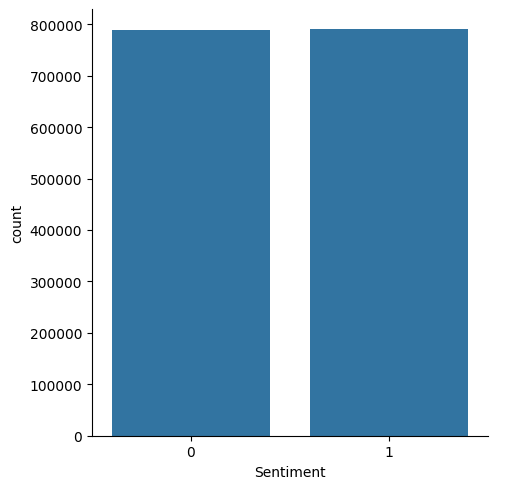

In [6]:
print("Basic information on train dataset: \n", df.info())

print("\n Unique 'Sentiment' values in train: \n", df.Sentiment.unique())

#Interessante ver a distribuição de categorias de valores de sentimento (0,1)
pos_count = df[df.Sentiment==1].count()
print("\n Record count with positive sentiments:\n",pos_count)

neg_count = df[df.Sentiment==0].count()
print("\n Record count with negative sentiments:\n",neg_count)

# Vamos visualizar como está a distribuição com um simple catplot
sns.catplot(x='Sentiment', kind='count', data=df)

# Nada mal, praticamente equilibrado com uma ligeira inclinação para o sentimento positivo
## Veja alguns exemplos de sentimento positivo(1) e negativo(0)
print("\n Examples with positive sentiments:\n")
display(df[df.Sentiment==1].head(10))

print("\n Examples with negative sentiments:\n")
display(df[df.Sentiment==0].head(10))

## Tratamento dos dados

Para o tratamento dos dados vou separar 100.000 amostras aliatorias.

In [7]:
df_amos = (df.sample(100000)
             .drop(columns=['ItemID', 'SentimentSource'])
             .rename(columns={'Sentiment': 'sentiment', 'SentimentText': 'sentimentText'}))

pos_count = df_amos[df_amos.sentiment==1].count()
print("\n Record count with positive sentiments:\n",pos_count)

neg_count = df_amos[df_amos.sentiment==0].count()
print("\n Record count with negative sentiments:\n",neg_count)


 Record count with positive sentiments:
 sentiment        50303
sentimentText    50303
dtype: int64

 Record count with negative sentiments:
 sentiment        49697
sentimentText    49697
dtype: int64


In [8]:
df.columns

Index(['ItemID', 'Sentiment', 'SentimentSource', 'SentimentText'], dtype='object')

In [9]:
# Importações necessárias
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import auc, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

# Instalação da NLTK e download dos pacotes necessários
# Descomente as linhas abaixo se precisar instalar e fazer o download
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Função para limpar o tweet
def clean_tweet_advanced(tweet):
    # Removendo URLs
    tweet = re.sub(r"http\S+|www\S+|https\S+", ' ', tweet, flags=re.MULTILINE)
    # Removendo menções a usuários e hashtags
    tweet = re.sub(r'\@\w+|\#', ' ', tweet)
    # Remover hashtags, mas manter o texto
    tweet = re.sub(r'#', '', tweet)
    # Remover caracteres especiais e números
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)

    # Tokenização
    word_tokens = word_tokenize(tweet)
    # Removendo a pontuação
    word_tokens = [word for word in word_tokens if word.isalnum()]
    # Removendo stop words e palavras com menos de 3 caracteres
    stop_words = set(stopwords.words('english'))
    filtered_tweet = [word for word in word_tokens if not word.lower() in stop_words and len(word) > 2]
    # Lemmatização
    lemmatizer = WordNetLemmatizer()
    lemmatized_tweet = [lemmatizer.lemmatize(word) for word in filtered_tweet]

    # Convertendo a lista de palavras lemmatizadas em uma string
    cleaned_tweet = ' '.join(lemmatized_tweet)

    # Retornar None se a string estiver vazia
    return cleaned_tweet if cleaned_tweet.strip() != '' else None

# Aplicando a limpeza aos dados
df_amos['sentimentText'] = df_amos['sentimentText'].apply(clean_tweet_advanced)
df_amos.dropna(subset=['sentimentText'], inplace=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Treinamento do modelo

In [10]:
# Dividindo os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(df_amos['sentimentText'], df_amos['sentiment'], test_size=0.3, random_state=42)

# Vetorização dos textos usando TfidfVectorizer
# Escolha o número máximo de features conforme necessário
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

In [11]:
# Função para testar múltiplos modelos e hiperparâmetros
def find_best_model_with_grid_search(X_train, y_train):
    models = {
        'logistic_regression': {
            'model': LogisticRegression(),
            'params': {
                'clf__C': [1, 5, 10]
            }
        },
        'decision_tree': {
            'model': DecisionTreeClassifier(),
            'params': {
                'clf__max_depth': [5, 10, 20],
                'clf__min_samples_leaf': [1, 2, 5]
            }
        },
        'random_forest': {
            'model': RandomForestClassifier(),
            'params': {
                'clf__n_estimators': [10, 50, 100],
                'clf__max_depth': [5, 10, 20]
            }
        },
        'SVM': {
            'model': SVC(),
            'params': {
                'clf__C': [0.1, 1, 10],
                'clf__kernel': ['rbf', 'linear']
            }
        },
        'knn': {
            'model': KNeighborsClassifier(),
            'params': {
                'clf__n_neighbors': [3, 5, 7]
            }
        }
    }

    scores = []
    best_estimators = {}
    for model_name, mp in models.items():
        pipe = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=5000)),
            ('clf', mp['model'])
        ])
        clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
        clf.fit(X_train, y_train)
        scores.append({
            'model': model_name,
            'best_score': clf.best_score_,
            'best_params': clf.best_params_
        })
        best_estimators[model_name] = clf.best_estimator_
    return scores, best_estimators

# Encontrando o melhor modelo
model_scores, best_models = find_best_model_with_grid_search(X_train, y_train)

# Avaliando o melhor modelo
best_model_name = max(model_scores, key=lambda item: item['best_score'])['model']

# Acessando os melhores hiperparâmetros
best_params = max(model_scores, key=lambda item: item['best_score'])['best_params']

# Acessando o melhor modelo
best_model = best_models[best_model_name]


y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Melhor Modelo:", best_model_name)
print("Acurácia do melhor modelo:", accuracy)
print("Melhores Hiperparâmetros:", best_params)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Melhor Modelo: SVM
Acurácia do melhor modelo: 0.7674722622599135
Melhores Hiperparâmetros: {'clf__C': 1, 'clf__kernel': 'rbf'}


In [12]:
# Inicialize o classificador SVM com os melhores hiperparâmetros
best_model = SVC(C=1, kernel='rbf')

# Crie o pipeline com o vetorizador TF-IDF e o classificador SVM
pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('clf', best_model)
])

# Treine o modelo com todos os dados de treinamento
pipeline.fit(df_amos['sentimentText'], df_amos['sentiment'])

# Faça previsões com o modelo treinado
predictions = pipeline.predict(X_test)

# Calcule e imprima outras métricas de avaliação
accuracy = accuracy_score(y_test, predictions)
print("Acurácia: %0.2f" % accuracy)
print("Relatório de Classificação:")
print(classification_report(y_test, predictions))

Acurácia: 0.91
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     14862
           1       0.90      0.92      0.91     14971

    accuracy                           0.91     29833
   macro avg       0.91      0.91      0.91     29833
weighted avg       0.91      0.91      0.91     29833



## Visualização do treinamento

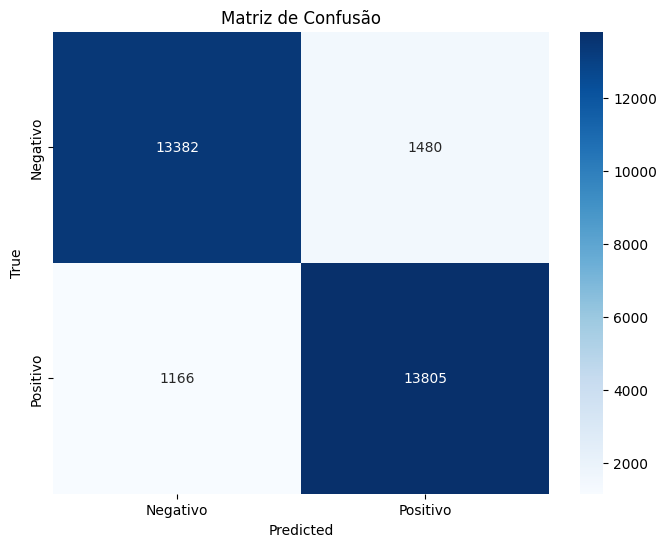

In [13]:
# Código para plotar a Matriz de Confusão
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Gerando a matriz de confusão
cm = confusion_matrix(y_test, predictions)

# Plotando a matriz de confusão
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão')
plt.show()

## Testando novos Tweets

In [14]:
novos_tweets_comuns = [
    "Absolutely thrilled with my purchase! High quality and quick shipping.",
    "Fantastic customer support! They solved my issue in minutes.",
    "Just had the best meal ever at your restaurant, everything was perfect! 😍",
    "I'm in love with these shoes! So comfortable and stylish! 👠💖",
    "Thanks for the incredible experience! I’ll cherish these memories forever.",
    "Terribly disappointed with the service, won’t be returning.",
    "Product broke after one use, total waste of money.",
    "Had a horrible time, the staff was rude and unhelpful.",
    "Extremely poor quality, looks nothing like the pictures online.",
    "Waited over an hour past my appointment, completely unacceptable!"
]

# Usando o pipeline para fazer previsões nos novos tweets
novas_previsoes = pipeline.predict(novos_tweets_comuns)

# Imprimindo as previsões
for tweet, predicao in zip(novos_tweets_comuns, novas_previsoes):
    print(f"Tweet: {tweet}\nPrevisão: {'Positivo' if predicao == 1 else 'Negativo'}\n")

Tweet: Absolutely thrilled with my purchase! High quality and quick shipping.
Previsão: Positivo

Tweet: Fantastic customer support! They solved my issue in minutes.
Previsão: Positivo

Tweet: Just had the best meal ever at your restaurant, everything was perfect! 😍
Previsão: Positivo

Tweet: I'm in love with these shoes! So comfortable and stylish! 👠💖
Previsão: Positivo

Tweet: Thanks for the incredible experience! I’ll cherish these memories forever.
Previsão: Positivo

Tweet: Terribly disappointed with the service, won’t be returning.
Previsão: Negativo

Tweet: Product broke after one use, total waste of money.
Previsão: Negativo

Tweet: Had a horrible time, the staff was rude and unhelpful.
Previsão: Negativo

Tweet: Extremely poor quality, looks nothing like the pictures online.
Previsão: Negativo

Tweet: Waited over an hour past my appointment, completely unacceptable!
Previsão: Negativo



##Salvando o Modelo

In [15]:
import joblib

# Salvando o melhor modelo treinado
with open('/content/drive/MyDrive/TCC/Melhor_Modelo/best_model.pkl', 'wb') as pkl_file:
    joblib.dump(best_model, pkl_file)


## Dados externos

In [16]:
df_externo = pd.read_excel("/content/drive/MyDrive/TCC/Bases/dataset_tweet-scraper_Treinamento.xlsx")
df_externo.head(2)

,text
0,️ Rodrygo: “Foden thinks he's the British Mess...
1,my club still employs phil foden https://t.co/...


In [17]:
def clean_tweet_externo(tweet):
    # Removendo URLs
    tweet = re.sub(r"http\S+|www\S+|https\S+", ' ', tweet, flags=re.MULTILINE)
    # Removendo menções a usuários e hashtags
    tweet = re.sub(r'\@\w+|\#', ' ', tweet)
    # Remover hashtags, mas manter o texto
    tweet = re.sub(r'#', '', tweet)
    # Remover caracteres especiais e números
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)

    tweet = re.sub(r'\n', '', tweet)

    # Tokenização
    word_tokens = word_tokenize(tweet)
    # Removendo a pontuação
    word_tokens = [word for word in word_tokens if word.isalnum()]
    # Removendo stop words e palavras com menos de 3 caracteres
    stop_words = set(stopwords.words('english'))
    filtered_tweet = [word for word in word_tokens if not word.lower() in stop_words and len(word) > 2]

    return tweet

In [18]:
# Aplicando a limpeza aos dados
df_externo['text'] = df_externo['text'].apply(clean_tweet_externo)
df_externo.dropna(subset=['text'], inplace=True)

In [19]:
tweets = df_externo['text'].tolist()

In [20]:
# Lista para armazenar os resultados
resultados = []

# Usando o pipeline para fazer previsões nos novos tweets
novas_previsoes = pipeline.predict(tweets)

# Imprimindo e salvando os resultados
for tweet, predicao in zip(tweets, novas_previsoes):
    resultados.append([tweet, 'Positivo' if predicao == 1 else 'Negativo'])
    print(f"Tweet: {tweet}\nPrevisão: {'Positivo' if predicao == 1 else 'Negativo'}\n")


Tweet:  Rodrygo Foden thinks hes the British Messi laughs  
Previsão: Positivo

Tweet: my club still employs phil foden  
Previsão: Negativo

Tweet:   Since Pep Joined  
Previsão: Positivo

Tweet: Foden vs Real Madrid  Highlights Le diamant de city  
Previsão: Positivo

Tweet: So were like just not going to speak on that Fodens performance Nah Cool
Previsão: Positivo

Tweet: wE lsT bUt FoDeN sCrEd hIs pEn  
Previsão: Negativo

Tweet: I posted this on IG expecting Foden to thump one top bins   
Previsão: Positivo

Tweet: Your City side to face Real Madrid XI  Ederson Walker C Akanji Dias Gvardiol Rodrigo De Bruyne Bernardo Foden Grealish HaalandSUBS  Ortega Moreno Carson Stones Ake Kovacic Doku Alvarez Gomez Nunes Bobb Lewis ManCity   UCL  
Previsão: Positivo

Tweet: I dont think this was anywhere near a great performance from Foden especially because of his missed chance in the box In total Id give him a  I did have some takeaways regarding his positioning and the discourse around that

In [21]:

# Criando um DataFrame com os resultados
df = pd.DataFrame(resultados, columns=['Tweet', 'Previsão'])

# Salvando em Excel e CSV
df.to_excel('/content/drive/MyDrive/TCC/Bases/resultados.xlsx', index=False)
df.to_csv('/content/drive/MyDrive/TCC/Bases/resultados.csv', index=False)